In [2]:
import os
import sys
sys.path.insert(0,'..')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, colors
from sklearn.cluster import KMeans
import tikzplotlib 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from sklearn.preprocessing import normalize
import random
from scipy.spatial.distance import pdist

from src.utils.hdf_tools import load_from_hdf_with_regex
from src.utils.dataset_utils import u_diode_data_to_df
from src.datasets.rb_fpa_full_quench_V2 import RBFPAFullQuench_V2
from src.datasets.rb_fpa_prim_quench_ee_plateau_V2 import RBFPAPrimQuenchEEPlateau_V2
from src.utils.frequency_utils import get_fft_of_DataArray, scale_fft_amplitude
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight, plot_distribution_over_column, plot_component_distribution, plot_cweight_distribution_all_data

# Reevaluate components

In [14]:
def mean_pairwise_distance(matrix, metric='cosine', norm=True):   
    n_rows = matrix.shape[0]
    
    max_size = 500
    if n_rows > max_size:
        subsample_indices = random.sample(range(n_rows), max_size)
        matrix = matrix[subsample_indices, :]
        n_rows = max_size
    
    if norm:
        matrix = normalize(matrix, axis=1) #, norm='l1'
    
    distances =  pdist(matrix, metric=metric)
    mean_distance = np.nanmean(distances)

    return mean_distance

In [15]:
path = "../output/nmf_sensitivity_all_events.py/full_sens_V3/" 
path_IS = "../output/nmf_sensitivity_all_events.py/full_sens_V3_IS/" 

n_components = [2,3,4,5,6,7,8,9,10, 11,12,13,14,15,16,17,18,19,20]
window_functions = ["ones","hanning","bartlett","blackman","flattop","hamming","tukey"]
dist_measures = ['frobenius', 'kullback-leibler', 'itakura-saito']

df_results = pd.DataFrame()

# Walk through the directory and its subdirectories
n = 0
for dist_measure in dist_measures:
    for n_comp in n_components:
        for win in window_functions:
            print(n)
            df_results.loc[n, "n_components"] = n_comp
            df_results.loc[n, "beta_loss"] = dist_measure
            df_results.loc[n, "f_window"] = win
            
            if dist_measure == 'itakura-saito':
                filepath = path_IS + f"{win}_{n_comp}_mu_{dist_measure}_nndsvda_False/"
            else:
                filepath = path + f"{win}_{n_comp}_mu_{dist_measure}_nndsvda_False/"
             

            # Load the array from the file and append it to the list
            df = pd.read_csv(filepath + "components.csv", index_col='Unnamed: 0')
            W = df.values.T
            H = np.load(filepath + "c_weights.npy")             

            measures = ["weights", "comp", "weights_norm", "comp_norm"]
            for meas in measures:
                
                if "norm" in meas:
                    norm = True
                else:
                    norm = False
                    
                if "weights" in meas:
                    data = H
                elif "comp" in meas:
                    data = W.T
                    
                # corr matrix 200 x 200
                metrics = ['cosine', 'euclidean', 'sqeuclidean', "seuclidean", 'correlation', 'jensenshannon', 'sqeuclidean', 'chebyshev', 'canberra']
                for met in metrics: 
                    df_results.loc[n, f"{meas}_{met}"] = mean_pairwise_distance(data, metric=met, norm=norm) 
            n += 1

df_results.to_csv("comp_weight_anlysis4.csv", index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

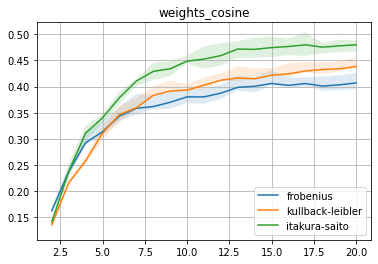

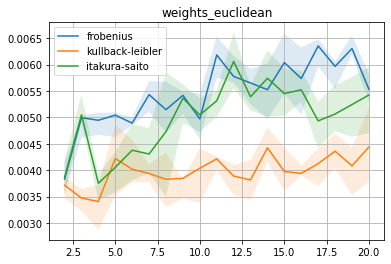

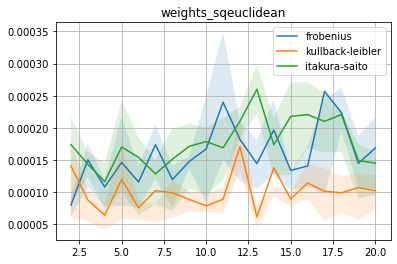

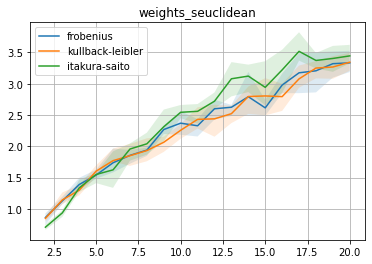

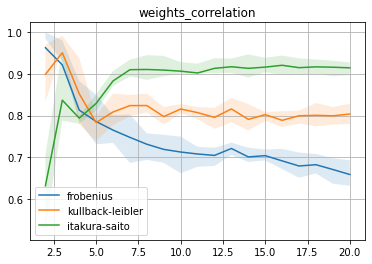

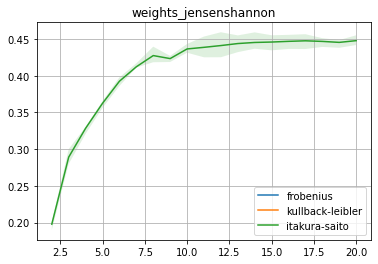

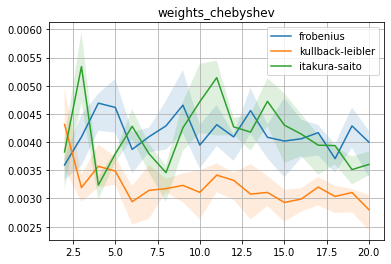

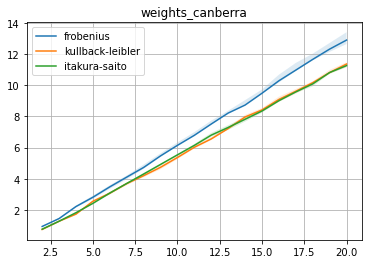

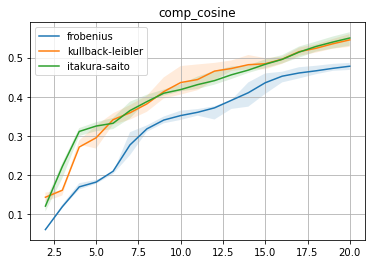

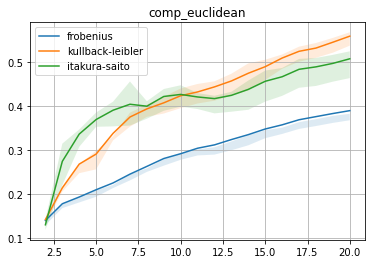

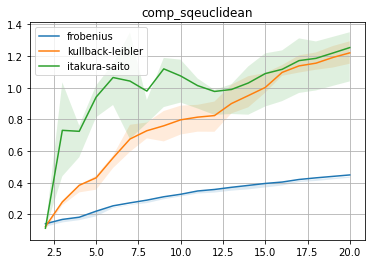

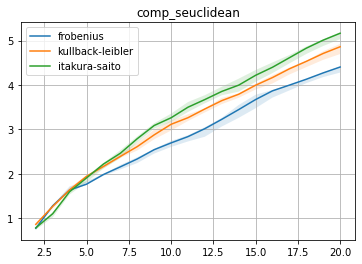

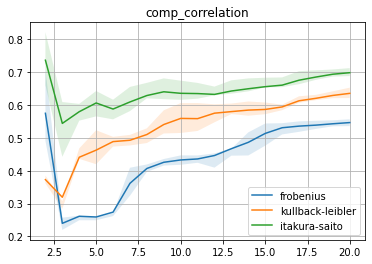

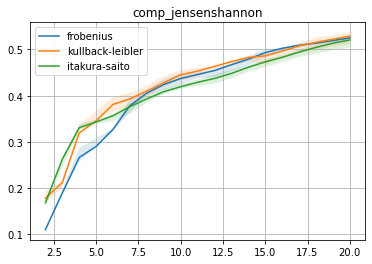

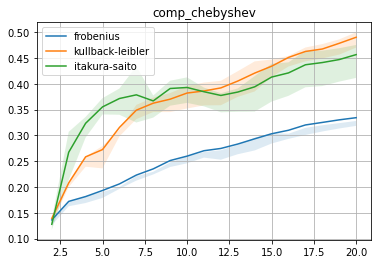

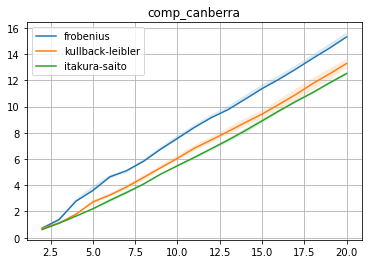

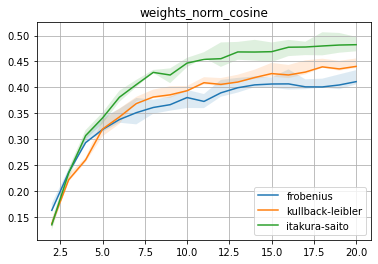

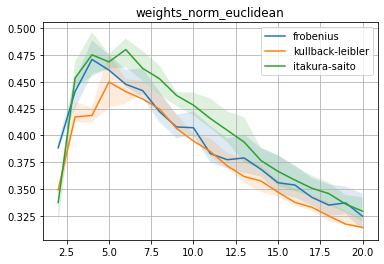

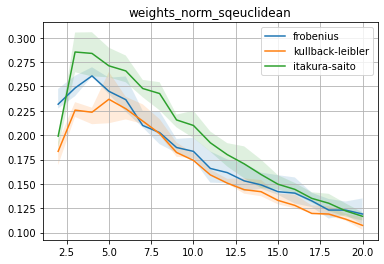

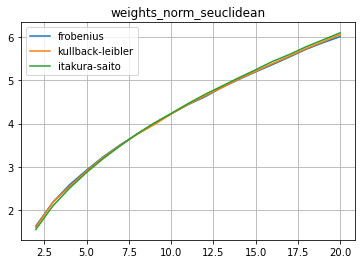

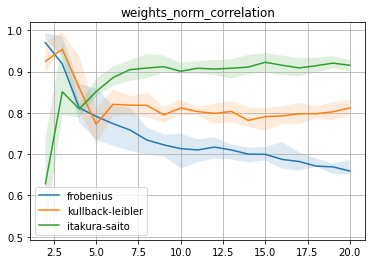

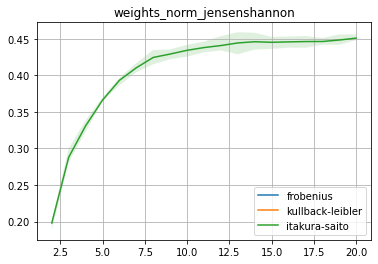

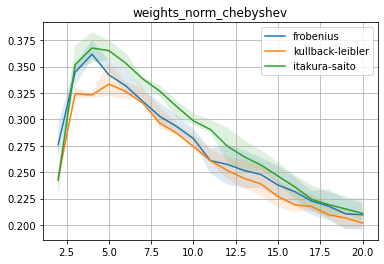

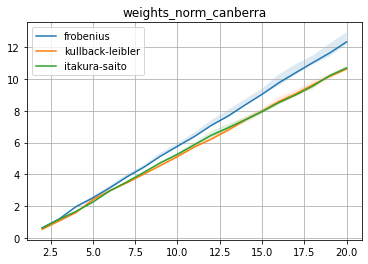

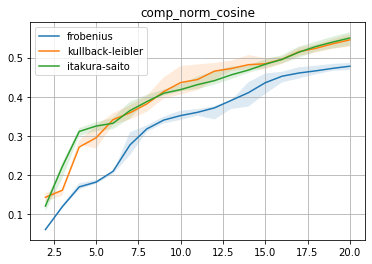

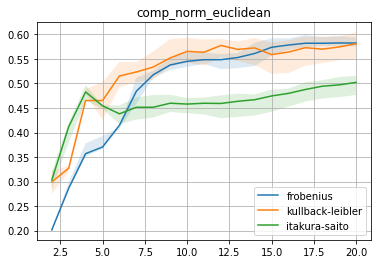

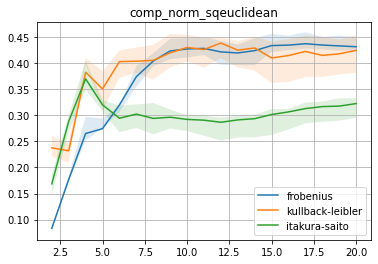

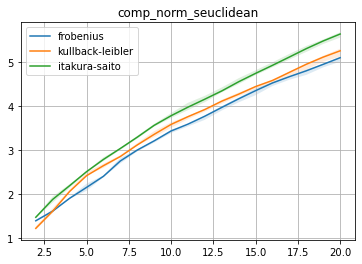

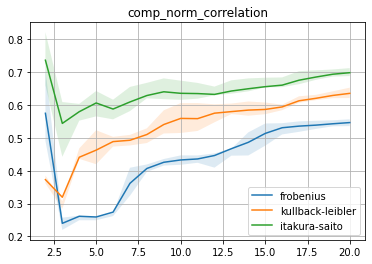

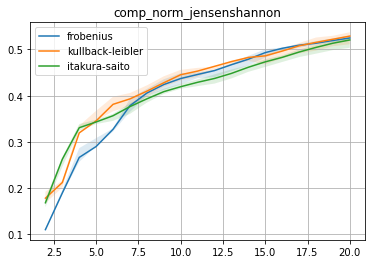

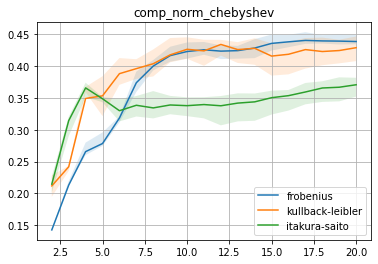

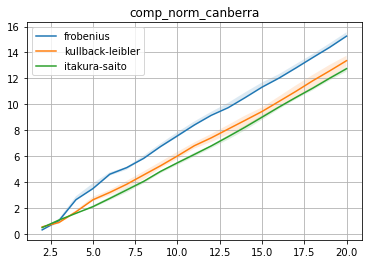

In [16]:
df_results = pd.read_csv("comp_weight_anlysis4.csv")

p_measures = df_results.drop(columns=["n_components","beta_loss","f_window"]).columns.values
dist_measures = ['frobenius', 'kullback-leibler', 'itakura-saito']

for p in p_measures:
    fig, ax = plt.subplots()
    for loss in dist_measures:
        df = df_results[df_results.beta_loss ==loss].groupby(["n_components"]).mean()[p]
        y = df.values
        x = df.index

        q1 = df_results[df_results.beta_loss ==loss].groupby(["n_components"]).quantile(0.25)[p].values 
        q3 = df_results[df_results.beta_loss ==loss].groupby(["n_components"]).quantile(0.75)[p].values

        plt.title(p)
        ax.plot(x ,y,'-', label = loss)
        plt.legend()
        ax.fill_between(x, q1, q3, alpha=.15)
        plt.grid()

# Brunet cophenic corleation

In [141]:
import numpy as np
from sklearn.decomposition import NMF
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cophenet

def calculate_cophenetic_correlation_coefficient(consensus_matrix):
    # Compute the dissimilarity matrix
    dissimilarity_matrix = 1 - consensus_matrix

    # Set the diagonal elements to zero
    np.fill_diagonal(dissimilarity_matrix, 0)
    
    # Compute the linkage matrix using average linkage method
    linkage_matrix = linkage(squareform(dissimilarity_matrix), method='ward')

    # Calculate the cophenetic correlation coefficient
    cophenetic_correlation_coefficient, _ = cophenet(linkage_matrix, pdist(dissimilarity_matrix))

    return cophenetic_correlation_coefficient

In [143]:
path = "../output/nmf_sensitivity_all_events.py/full_sens_V3/"

n_components = [2,3,4,5,6,7,8,9,10, 11,12,13,14,15,16,17,18,19,20]
df_results = pd.DataFrame(index=n_components)

window_functions = ["ones","hanning","bartlett","blackman","flattop","hamming","tukey"]
dist_measure = 'kullback-leibler'#['frobenius', 'kullback-leibler', 'itakura-saito']

df_results = pd.DataFrame(index=n_components)

n_all_samples = 215292
n_samples = 1000
subsample_indices = random.sample(range(n_all_samples), n_samples)

for n in n_components:
    consensus_matrix = np.zeros((n_samples, n_samples))

    for win in window_functions:
        filepath = path + f"{window_functions}_{n}_mu_kullback-leibler/c_weights.npy"
 
        # Load the array from the file and append it to the list
        H = np.load(os.path.join(root, "c_weights.npy"))
        H = H[subsample_indices, :]
        
        # Get the cluster assignments based on the highest component weight
        cluster_assignments = np.argmax(H, axis=1)     
        
        # Update the consensus matrix
        for j in range(n_samples):
            for k in range(j + 1, n_samples):
                if cluster_assignments[j] == cluster_assignments[k]:
                    consensus_matrix[j, k] += 1
                    consensus_matrix[k, j] += 1
                    
    # Normalize the consensus matrix
    consensus_matrix /= len(window_functions)
    
    # Calculate the cophenetic correlation coefficient
    cophenetic_correlation_coefficient = calculate_cophenetic_correlation_coefficient(consensus_matrix)
    print(n, cophenetic_correlation_coefficient)
    df_results.loc[n, "coph_corr"] =  cophenetic_correlation_coefficient

2 0.9788345166772019
3 0.9788345166772019
4 0.9788345166772019
5 0.9788345166772019
6 0.9788345166772019
7 0.9788345166772019
8 0.9788345166772019
9 0.9788345166772019
10 0.9788345166772019
11 0.9788345166772019
12 0.9788345166772019
13 0.9788345166772019
14 0.9788345166772019
15 0.9788345166772019
16 0.9788345166772019
17 0.9788345166772019
18 0.9788345166772019
19 0.9788345166772019
20 0.9788345166772019


# Merge compontents

In [3]:
# Initialize an empty list to store the loaded arrays
W_all_list = []
H_all_list = []
exp_name = []
path = "../output/nmf_sensitivity_k20/" 

n_components = [20]
n_components_unsorted = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(path):
    for file in files:
        for n in n_components:
            
            # Check if the file has a .npy extension
            if file.endswith('.csv') & (f'ones_{n}_mu' in root):
                print(root, file)
                # Load the array from the file and append it to the list
                df = pd.read_csv(os.path.join(root, file), index_col='Unnamed: 0')
                W_all_list.append(df.values)
                
                H_temp = np.load(os.path.join(root, "c_weights.npy"))
                H_all_list.append(H_temp)
                
                n_components_unsorted.append(n)
                exp_name.append(root[len(path):])
                
#W_all = np.stack(W_all_list)
#H_all = np.stack(H_all_list)

../output/nmf_sensitivity_k20/1EE_2EE/ones_20_mu_frobenius_nndsvda_False components.csv
../output/nmf_sensitivity_k20/1EE_2EE/ones_20_mu_itakura-saito_nndsvda_False components.csv
../output/nmf_sensitivity_k20/1EE_2EE/ones_20_mu_kullback-leibler_nndsvda_False components.csv


In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn import metrics

def get_cluster_error(X, n_clusters_range):
    
    scores = ["correlation"]#, "silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"]
    df_results = pd.DataFrame(np.zeros((len(n_clusters_range), len(scores))), columns = scores, index=n_clusters_range)
    
    # Loop through the range of n_clusters and fit AgglomerativeClustering
    for n_clusters in n_clusters_range:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
        labels = clustering.fit_predict(X)
        
        H_merged = np.empty((n_clusters,len(X[0])))
        for i in range(n_clusters):
            idx = np.where(labels == i)
            H_merged[i] = np.sum(X[idx], axis=0) 
            
        
        idx_corr = np.triu_indices(n_clusters, k=1)
        corr = np.mean(np.corrcoef(H_merged)[idx_corr])
        #corr = np.corrcoef(pdist(H_merged))
        
        # Calculate performance measures
        df_results.loc[n_clusters, "correlation"] = corr
        df_results.loc[n_clusters, "silhouette_score"] = metrics.silhouette_score(X, labels)
        df_results.loc[n_clusters, "calinski_harabasz_score"] = metrics.calinski_harabasz_score(X, labels)
        df_results.loc[n_clusters, "davies_bouldin_score"] = metrics.davies_bouldin_score(X, labels)
        
    return df_results

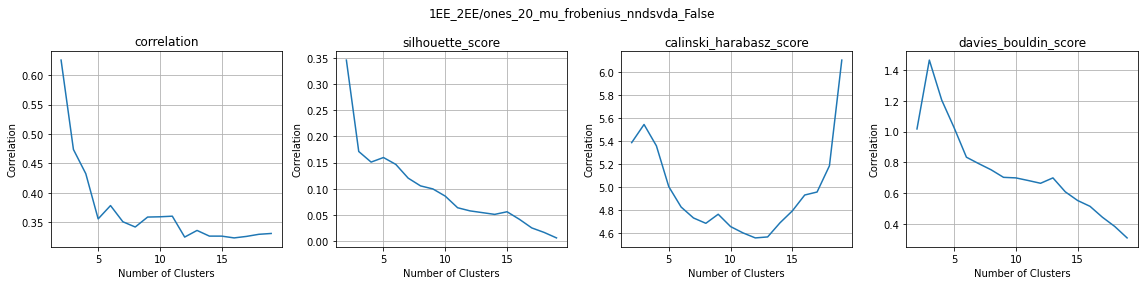

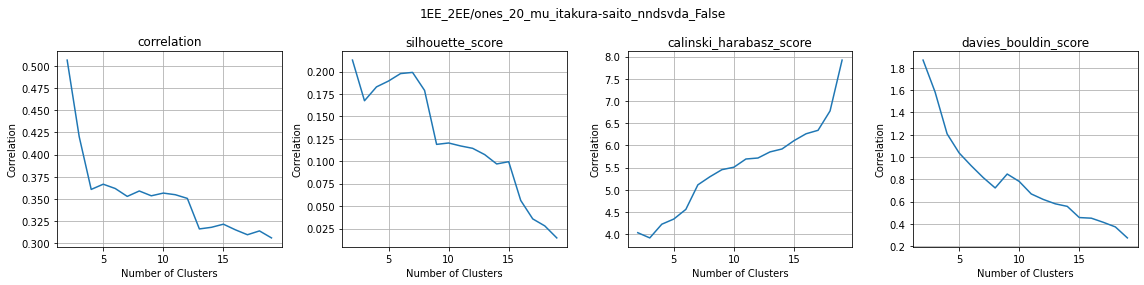

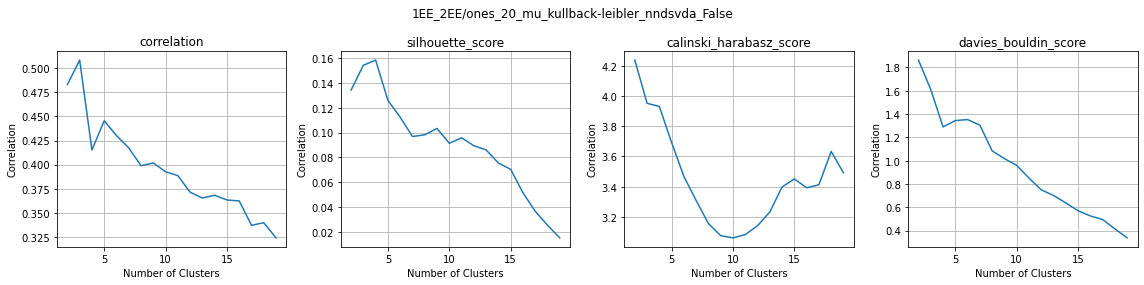

In [7]:
# Set the range of n_clusters to test
n_clusters_range = range(2, 20)

all_e = []
for e, exp in enumerate(exp_name):
    df_results = get_cluster_error(H_all_list[e].T, n_clusters_range)
    
    all_e.append(df_results)
    # Plot the errors against the range of n_clusters
    fig, ax = plt.subplots(1,len(df_results.columns),figsize=(4*len(df_results.columns), 4))
    for i, c in enumerate(df_results.columns):
        df_results[c].plot(ax=ax[i])
        ax[i].set_xlabel('Number of Clusters')
        ax[i].set_ylabel('Correlation')
        ax[i].set_title(c)
        ax[i].grid()
    fig.suptitle(exp)
    plt.tight_layout()
    plt.show()

In [19]:
def plot_merged_components(X, W, n_clusters, title):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = clustering.fit_predict(X)

    W_merged = np.empty((len(W), n_clusters))
    for i in range(n_clusters):
        idx = np.where(labels == i)
        W_to_merge = W.T[idx]
        W_merged[:, i] = np.sum(W_to_merge , axis=0) 


    fig, ax = plt.subplots(1,n_clusters, figsize=(3.5*n_clusters, 2.625))
    for i in range(n_clusters):
        ax[i].plot(df_components.index, W_merged[:, i])
        ax[i].set_xlim((0, 250))
    fig.suptitle(title)

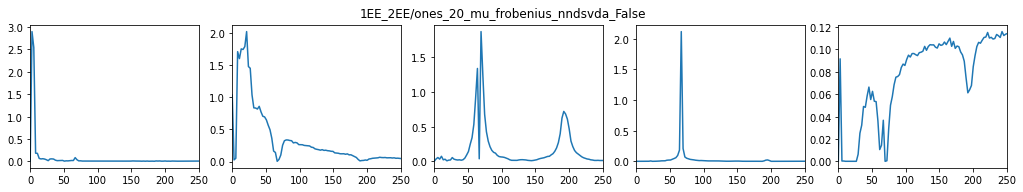

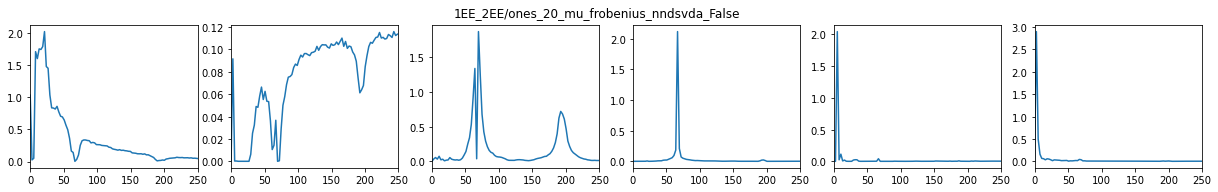

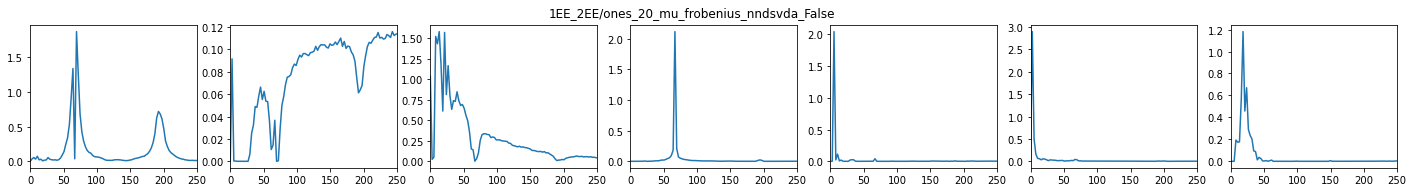

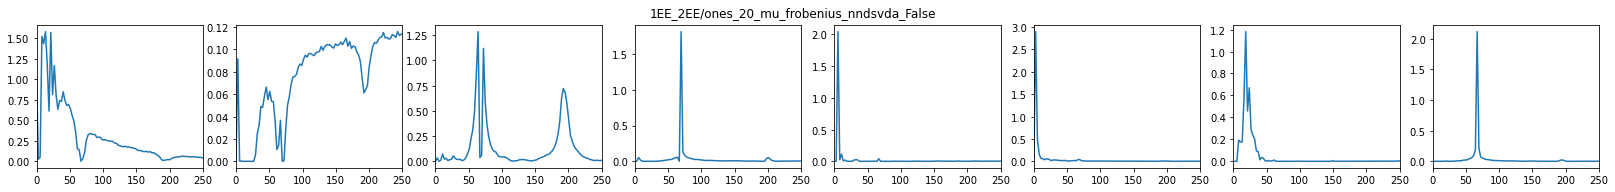

In [20]:
e =0
for n in range(5,9):
    X = H_all_list[e].T
    plot_merged_components(H_all_list[e].T, W_all_list[e], n, exp_name[e])

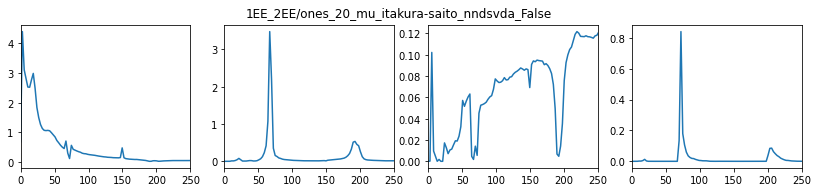

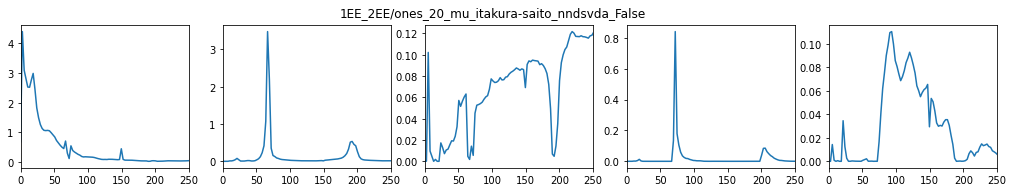

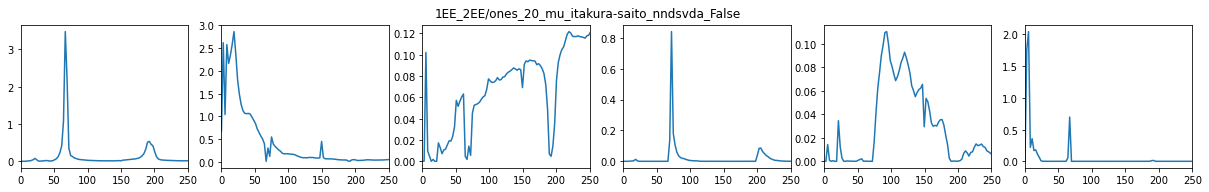

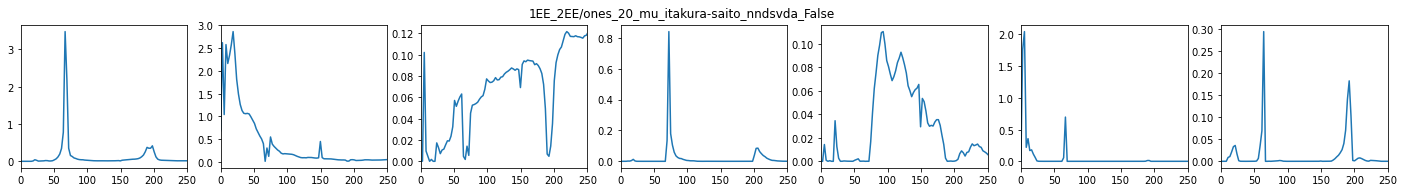

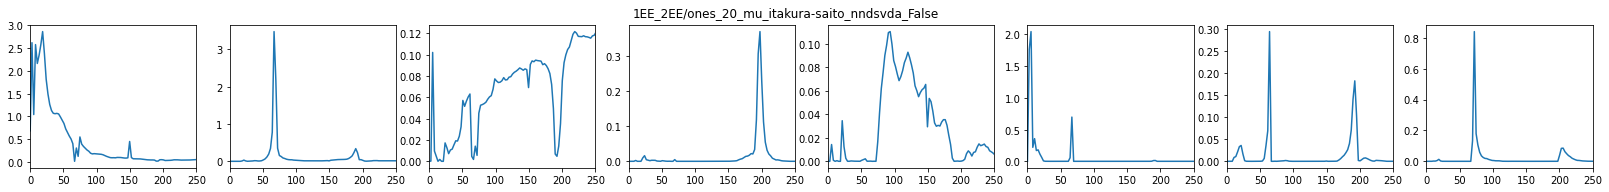

In [23]:
e =1
for n in range(4,9):
    X = H_all_list[e].T
    plot_merged_components(H_all_list[e].T, W_all_list[e], n, exp_name[e])

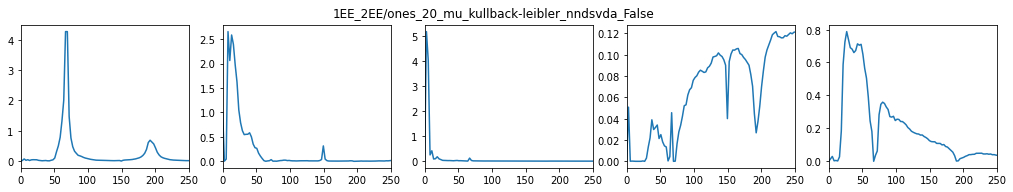

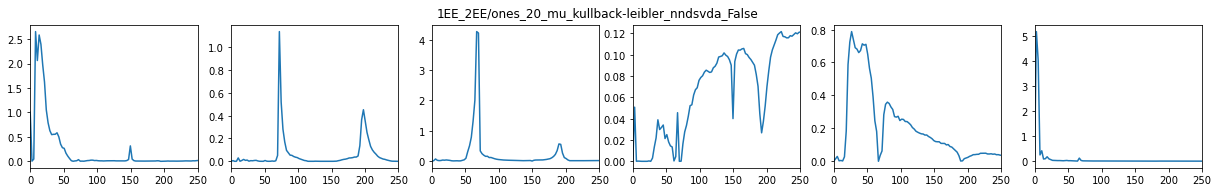

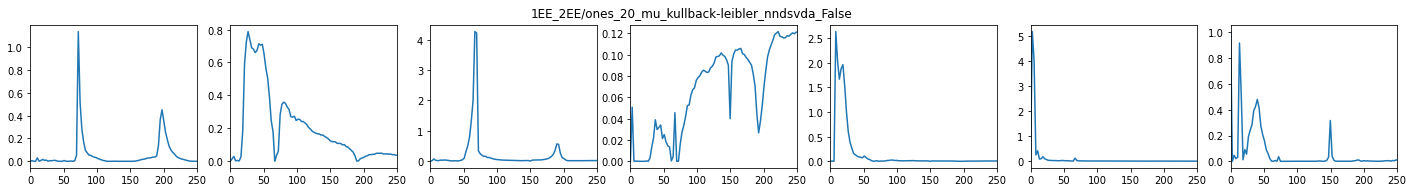

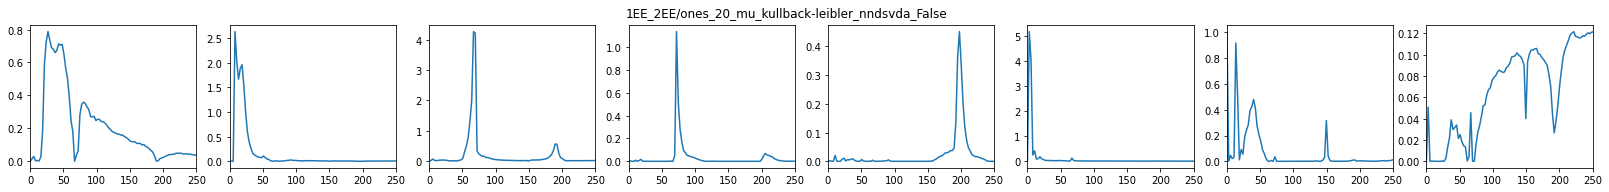

In [22]:
e = 2
for n in range(5,9):
    X = H_all_list[e].T
    plot_merged_components(H_all_list[e].T, W_all_list[e], n, exp_name[e])

In [ ]:
# Reconstruction